##GAN CODE
The following notebook contains all the GAN code for the TB Capstone Assignment. I found the GAN architecture here [GAN Example](https://samanemami.medium.com/gan-on-tabular-data-example-with-code-96b1b09c08c4). To run this code upload the data file with the base data files to your colab notebooks folder of google drive. Or you can run locally by removing the google drive code and changing the file path variables to their location on your local machine.

We decided to use a GAN for this project because GANs are a very powerful, very customizable architecture for generating synthetic data. By using two small DNNs we can feed our relatively low dimensional data through and generate synthetic data that matches the data distribution of the real data.

In [ ]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

class Gan():

    def __init__(self, data):
        self.data = data
        self.n_epochs = 200

    # Generate random noise in a latent space
    def _noise(self):
        noise = np.random.normal(0, 1, self.data.shape)
        return noise

    #Method to build the generator
    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(30, activation='relu'))
        model.add(tf.keras.layers.Dense(
            self.data.shape[1], activation='linear'))
        return model

    #Method to build the discriminator
    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    #Define the combined model to train the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    def train(self, generator, discriminator, gan):

        dis_loss = []
        gen_loss = []
        for epoch in range(self.n_epochs):

            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))

            dis_loss.append(d_loss)
            gen_loss.append(g_loss)

            print('>%d, d1=%.3f, d2=%.3f' %(epoch+1, d_loss, g_loss))

        #Plot Discriminator and Generator Loss
        plt.plot(dis_loss, label='Discriminator Loss')
        plt.plot(gen_loss, label='Generator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.legend()
        plt.show()

        return generator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##MinMax Data

This is the code for generating the new MinMax data with synthetic values. The GAN is trained on the three different minority classes and the new data has an equal proportion of all classes. The file is then saved to a CSV.

In [ ]:
#Load and view the head of the MinMax data
minmax = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TB_Data/tb_drug_data_minmax.csv')

minmax.head()

,Recurrent,Gender,Age,Residence time,Nationality,Occupation,Education,Revenue,No. families,Tb in family,...,Sympomless,Have similar sym before,X-ray checking,Sputum specimen,Tb diagnosed,Clinical record checked,Anti-tb drug time,Patient final type decided,Subserotype type,TB Type
0,0.0,0.0,0.061728,0.164835,0.0,9.0,3.0,3.0,0.230769,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.125,1.0,0.0,3.0
1,0.0,0.0,0.160494,0.208791,0.0,0.0,2.0,0.0,0.307692,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,0.0,0.0,0.0
2,0.0,0.0,0.506173,0.560440,0.0,0.0,2.0,0.0,0.384615,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.000,0.0,0.0,3.0
3,0.0,0.0,0.765432,0.791209,0.0,0.0,0.0,1.0,0.230769,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,0.0,3.0
4,0.0,0.0,0.567901,0.615385,0.0,0.0,3.0,1.0,0.384615,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.000,0.0,0.0,3.0


In [ ]:
#Change the numeric target variable into the desired drug resistances types
conditions = [
    (minmax['TB Type'] == 0.0),
    (minmax['TB Type'] == 1.0),
    (minmax['TB Type'] == 2.0),
    (minmax['TB Type'] == 3.0)
]

new_values = ['Single', 'Multi', 'Poly', 'Regular']

# Apply conditional replacement
minmax['TB Type'] = np.select(conditions, new_values, default=minmax['TB Type'])
minmax['Real'] = 1

In [ ]:
minmax['TB Type'].value_counts()

,count
TB Type,
Regular,1064
Single,262
Poly,105
Multi,95


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
>1, d1=0.883, d2=0.698
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>2, d1=0.867, d2=0.671
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>3, d1=0.849, d2=0.654
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>4, d1=0.834, d2=0.636
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>5, d1=0.822, d2=0.619
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>6, d1=0.811, d2=0.600
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>7, d1=0.800, d2=0.581
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>8, d1=0.793, d2=0.564
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>9, d1=0.788, d2=0.549
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>10, d1=0.784, d2=0.534
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>11, d1=0.781, d2=0.520
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
>12, d1=0.781, d2=0.507
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>13, d1=0.779, d2=0.493
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>14, d1=0.782, d2=0.480
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>15, d1=0.785, d2=0.469
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>16, d1=0.789, d2=0.458
9/9 ━━━━━━━━━━━━━

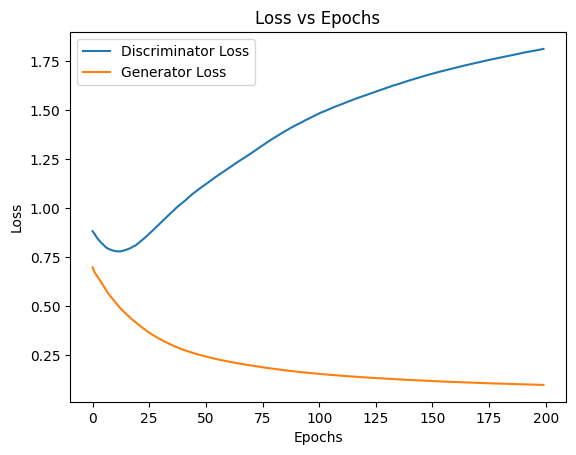

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
>1, d1=0.615, d2=0.635
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>2, d1=0.605, d2=0.623
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>3, d1=0.598, d2=0.619
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>4, d1=0.592, d2=0.607
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>5, d1=0.588, d2=0.596
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>6, d1=0.587, d2=0.585
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>7, d1=0.586, d2=0.576
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>8, d1=0.585, d2=0.567
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>9, d1=0.583, d2=0.558
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>10, d1=0.582, d2=0.549
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>11, d1=0.584, d2=0.542
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>12, d1=0.589, d2=0.532
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>13, d1=0.593, d2=0.524
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>14, d1=0.596, d2=0.515
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>15, d1=0.602, d2=0.508
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>16, d1=0.607, d2=0.500
4/4 ━━━━━━━━━━━━━

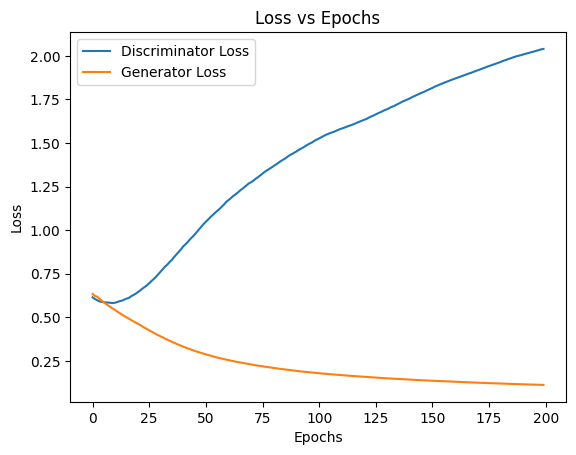

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1, d1=0.690, d2=0.802
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>2, d1=0.680, d2=0.765
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>3, d1=0.676, d2=0.747
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>4, d1=0.669, d2=0.722
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>5, d1=0.662, d2=0.703
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>6, d1=0.657, d2=0.681
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>7, d1=0.658, d2=0.665
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>8, d1=0.657, d2=0.647
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>9, d1=0.658, d2=0.633
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>10, d1=0.660, d2=0.617
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>11, d1=0.660, d2=0.601
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>12, d1=0.663, d2=0.588
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>13, d1=0.664, d2=0.573
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>14, d1=0.668, d2=0.561
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>15, d1=0.671, d2=0.550
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>16, d1=0.676, d2=0.539
3/3 ━━━━━━━━━━━━━

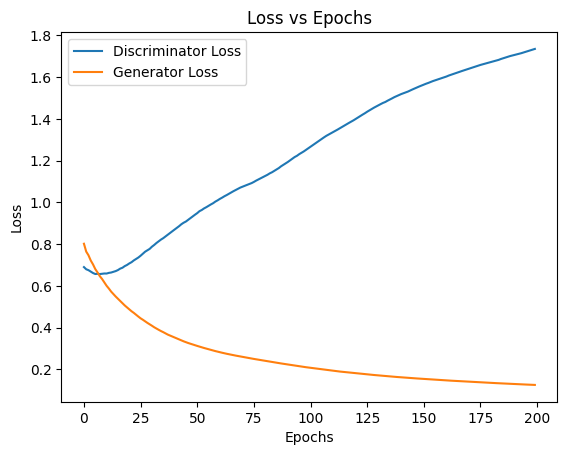

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
types = ['Single', 'Poly', 'Multi']

#Loop through the three minority classes, train the GAN on the class, generate new data for the class, report the loss
for tb_type in types:
  trim_data_frame = minmax[minmax['TB Type'] == tb_type]
  trim_data_frame = trim_data_frame.drop(['TB Type', 'Real'], axis=1)
  trim_data = trim_data_frame.to_numpy()
  trim_GAN = Gan(trim_data)
  trim_generator = trim_GAN._generator()
  trim_discriminator = trim_GAN._discriminator()
  trim_gan_model = trim_GAN._GAN(trim_generator, trim_discriminator)

  trim_generator_trained = trim_GAN.train(trim_generator, trim_discriminator, trim_gan_model)

  new_data = trim_generator_trained.predict(np.random.normal(0, 1, [1064-trim_data.shape[0],27]))
  new_data_frame = pd.DataFrame(new_data, columns=trim_data_frame.columns)
  new_data_frame['TB Type'] = tb_type
  new_data_frame['Real'] = 0

  if tb_type == "Single":
    new_minmax = pd.concat([minmax, new_data_frame], ignore_index=True)
  else:
    new_minmax = pd.concat([new_minmax, new_data_frame], ignore_index=True)

In [ ]:
new_minmax['TB Type'].value_counts()

,count
TB Type,
Regular,1064
Single,1064
Poly,1064
Multi,1064


In [ ]:
new_minmax.to_csv('minmax_gan.csv')

##MaxAbs Data
This is the code for generating the new MaxAbs data with synthetic values. The GAN is trained on the three different minority classes and the new data has an equal proportion of all classes. The file is then saved to a CSV.

In [ ]:
#Load and view the head of MaxAbs data
maxabs = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TB_Data/tb_drug_data_maxabs.csv')

maxabs.head()

,Recurrent,Gender,Age,Residence time,Nationality,Occupation,Education,Revenue,No. families,Tb in family,...,Sympomless,Have similar sym before,X-ray checking,Sputum specimen,Tb diagnosed,Clinical record checked,Anti-tb drug time,Patient final type decided,Subserotype type,TB Type
0,0.0,0.0,0.173913,0.173913,0.0,9.0,3.0,3.0,0.230769,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.222222,1.0,0.0,3.0
1,0.0,0.0,0.260870,0.217391,0.0,0.0,2.0,0.0,0.307692,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.0,0.0
2,0.0,0.0,0.565217,0.565217,0.0,0.0,2.0,0.0,0.384615,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.000000,0.0,0.0,3.0
3,0.0,0.0,0.793478,0.793478,0.0,0.0,0.0,1.0,0.230769,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,0.0,3.0
4,0.0,0.0,0.619565,0.619565,0.0,0.0,3.0,1.0,0.384615,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.0,3.0


In [ ]:
#Change the numeric target variable into the desired drug resistances types
conditions = [
    (maxabs['TB Type'] == 0.0),
    (maxabs['TB Type'] == 1.0),
    (maxabs['TB Type'] == 2.0),
    (maxabs['TB Type'] == 3.0)
]

new_values = ['Single', 'Multi', 'Poly', 'Regular']

# Apply conditional replacement
maxabs['TB Type'] = np.select(conditions, new_values, default=maxabs['TB Type'])
maxabs['Real'] = 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
>1, d1=0.664, d2=0.990
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>2, d1=0.652, d2=0.950
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>3, d1=0.640, d2=0.919
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>4, d1=0.629, d2=0.884
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>5, d1=0.620, d2=0.851
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>6, d1=0.614, d2=0.820
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>7, d1=0.609, d2=0.796
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>8, d1=0.606, d2=0.772
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>9, d1=0.604, d2=0.748
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>10, d1=0.603, d2=0.728
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>11, d1=0.602, d2=0.708
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>12, d1=0.602, d2=0.691
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>13, d1=0.604, d2=0.674
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>14, d1=0.605, d2=0.658
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>15, d1=0.607, d2=0.644
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
>16, d1=0.610, d2=0.630
9/9 ━━━━━━━━━━━━━

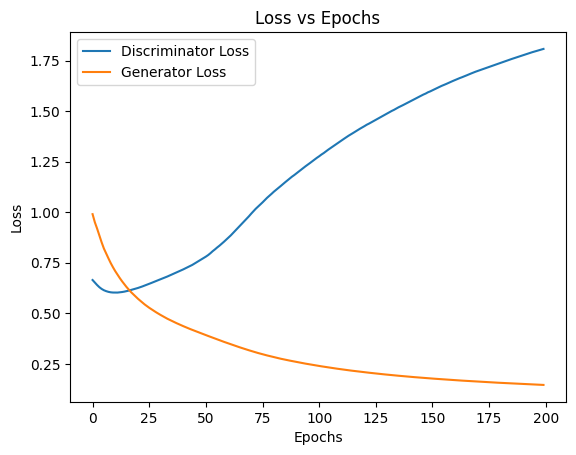

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1, d1=0.653, d2=0.607
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>2, d1=0.654, d2=0.596
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>3, d1=0.660, d2=0.586
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>4, d1=0.657, d2=0.575
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>5, d1=0.657, d2=0.567
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>6, d1=0.657, d2=0.556
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>7, d1=0.656, d2=0.545
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>8, d1=0.657, d2=0.534
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>9, d1=0.658, d2=0.524
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>10, d1=0.660, d2=0.516
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>11, d1=0.665, d2=0.507
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>12, d1=0.668, d2=0.499
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>13, d1=0.672, d2=0.492
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>14, d1=0.675, d2=0.484
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>15, d1=0.681, d2=0.475
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>16, d1=0.687, d2=0.465
4/4 ━━━━━━━━━━━━━

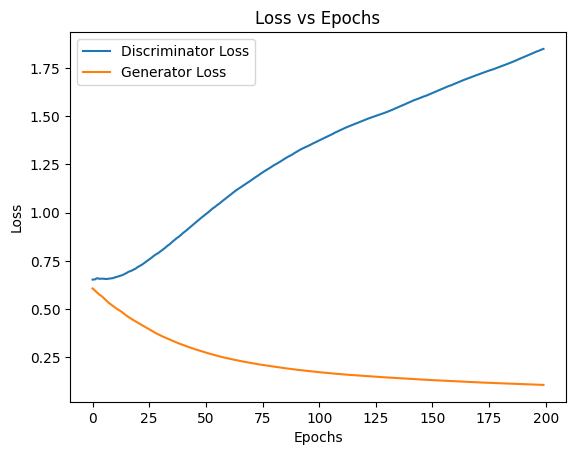

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1, d1=0.650, d2=0.575
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>2, d1=0.651, d2=0.554
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>3, d1=0.639, d2=0.534
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>4, d1=0.636, d2=0.510
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>5, d1=0.638, d2=0.490
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>6, d1=0.639, d2=0.479
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>7, d1=0.649, d2=0.468
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>8, d1=0.655, d2=0.459
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>9, d1=0.668, d2=0.446
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>10, d1=0.678, d2=0.434
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>11, d1=0.689, d2=0.424
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>12, d1=0.700, d2=0.410
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>13, d1=0.711, d2=0.401
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>14, d1=0.720, d2=0.389
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>15, d1=0.732, d2=0.379
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>16, d1=0.743, d2=0.370
3/3 ━━━━━━━━━━━━━

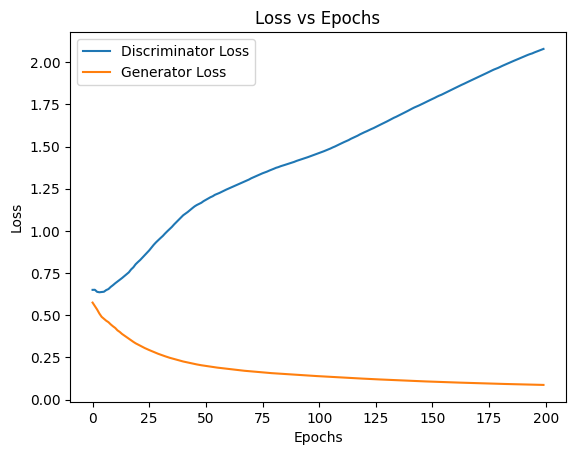

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
types = ['Single', 'Poly', 'Multi']

#Loop through the three minority classes, train the GAN on the class, generate new data for the class, report the loss
for tb_type in types:
  trim_data_frame = maxabs[maxabs['TB Type'] == tb_type]
  trim_data_frame = trim_data_frame.drop(['TB Type', 'Real'], axis=1)
  trim_data = trim_data_frame.to_numpy()
  trim_GAN = Gan(trim_data)
  trim_generator = trim_GAN._generator()
  trim_discriminator = trim_GAN._discriminator()
  trim_gan_model = trim_GAN._GAN(trim_generator, trim_discriminator)

  trim_generator_trained = trim_GAN.train(trim_generator, trim_discriminator, trim_gan_model)

  new_data = trim_generator_trained.predict(np.random.normal(0, 1, [1064-trim_data.shape[0],27]))
  new_data_frame = pd.DataFrame(new_data, columns=trim_data_frame.columns)
  new_data_frame['TB Type'] = tb_type
  new_data_frame['Real'] = 0

  if tb_type == "Single":
    new_maxabs = pd.concat([maxabs, new_data_frame], ignore_index=True)
  else:
    new_maxabs = pd.concat([new_maxabs, new_data_frame], ignore_index=True)

In [ ]:
new_maxabs['TB Type'].value_counts()

,count
TB Type,
Regular,1064
Single,1064
Poly,1064
Multi,1064


In [ ]:
new_maxabs.to_csv('maxabs_gan.csv')

##Robust Data
This is the code for generating the new Robust data with synthetic values. The GAN is trained on the three different minority classes and the new data has an equal proportion of all classes. The file is then saved to a CSV.

In [ ]:
#Load and view the head of the Robust data
robust = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TB_Data/tb_drug_data_robust.csv')

robust.head()

,Recurrent,Gender,Age,Residence time,Nationality,Occupation,Education,Revenue,No. families,Tb in family,...,Sympomless,Have similar sym before,X-ray checking,Sputum specimen,Tb diagnosed,Clinical record checked,Anti-tb drug time,Patient final type decided,Subserotype type,TB Type
0,0.0,0.0,-0.87500,-0.757576,0.0,9.0,3.0,3.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,1.0,0.0,3.0
1,0.0,0.0,-0.62500,-0.636364,0.0,0.0,2.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.25000,0.333333,0.0,0.0,2.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0
3,0.0,0.0,0.90625,0.969697,0.0,0.0,0.0,1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0
4,0.0,0.0,0.40625,0.484848,0.0,0.0,3.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0


In [ ]:
#Change the numeric target variable into the desired drug resistances types
conditions = [
    (robust['TB Type'] == 0.0),
    (robust['TB Type'] == 1.0),
    (robust['TB Type'] == 2.0),
    (robust['TB Type'] == 3.0)
]

new_values = ['Single', 'Multi', 'Poly', 'Regular']

# Apply conditional replacement
robust['TB Type'] = np.select(conditions, new_values, default=robust['TB Type'])
robust['Real'] = 1

1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>1, d1=0.788, d2=0.584
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>2, d1=0.753, d2=0.571
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>3, d1=0.726, d2=0.554
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>4, d1=0.704, d2=0.541
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>5, d1=0.687, d2=0.526
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>6, d1=0.678, d2=0.514
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>7, d1=0.672, d2=0.501
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>8, d1=0.668, d2=0.488
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>9, d1=0.664, d2=0.478
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>10, d1=0.664, d2=0.467
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>11, d1=0.666, d2=0.457
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>12, d1=0.670, d2=0.448
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>13, d1=0.674, d2=0.439
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>14, d1=0.677, d2=0.430
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>15, d1=0.682, d2=0.421
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>16, d1=0.688, d2=0.412
9/9 ━━━━━━━━━━━━━

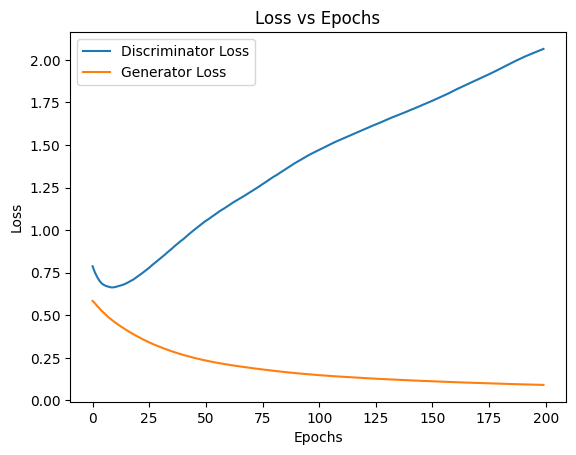

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1, d1=0.758, d2=0.633
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>2, d1=0.737, d2=0.618
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>3, d1=0.722, d2=0.603
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>4, d1=0.714, d2=0.593
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>5, d1=0.701, d2=0.582
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>6, d1=0.695, d2=0.568
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>7, d1=0.690, d2=0.559
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>8, d1=0.685, d2=0.546
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>9, d1=0.682, d2=0.536
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>10, d1=0.680, d2=0.526
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>11, d1=0.679, d2=0.516
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>12, d1=0.679, d2=0.505
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>13, d1=0.678, d2=0.495
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
>14, d1=0.678, d2=0.487
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>15, d1=0.682, d2=0.478
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
>16, d1=0.684, d2=0.469
4/4 ━━━━━━━━━━━━━

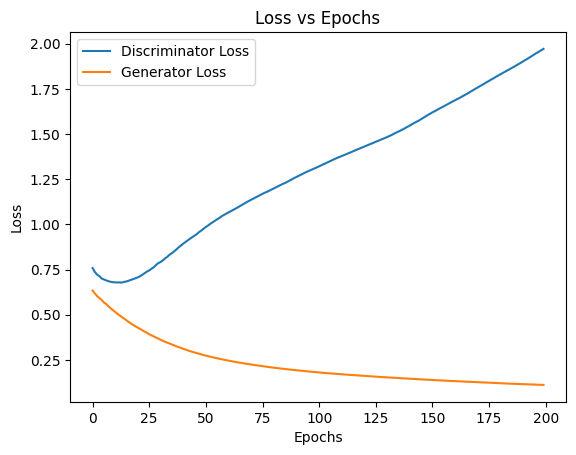

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1, d1=0.561, d2=0.844
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>2, d1=0.556, d2=0.822
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>3, d1=0.545, d2=0.804
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>4, d1=0.541, d2=0.791
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>5, d1=0.534, d2=0.771
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>6, d1=0.529, d2=0.755
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>7, d1=0.525, d2=0.739
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>8, d1=0.522, d2=0.725
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>9, d1=0.521, d2=0.711
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>10, d1=0.521, d2=0.698
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>11, d1=0.522, d2=0.686
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>12, d1=0.523, d2=0.674
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>13, d1=0.524, d2=0.664
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>14, d1=0.525, d2=0.653
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>15, d1=0.527, d2=0.642
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>16, d1=0.530, d2=0.632
3/3 ━━━━━━━━━━━━━

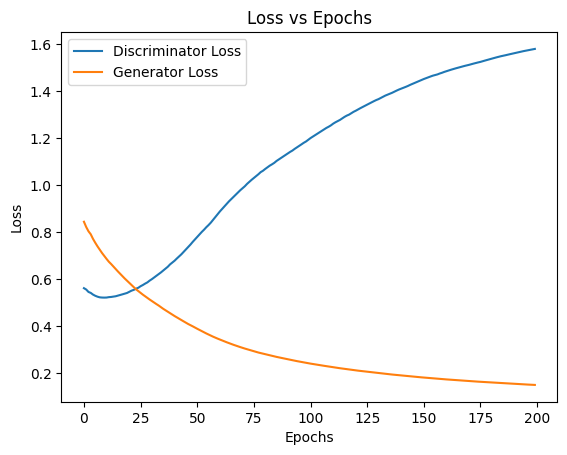

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
types = ['Single', 'Poly', 'Multi']

#Loop through the three minority classes, train the GAN on the class, generate new data for the class, report the loss
for tb_type in types:
  trim_data_frame = robust[robust['TB Type'] == tb_type]
  trim_data_frame = trim_data_frame.drop(['TB Type', 'Real'], axis=1)
  trim_data = trim_data_frame.to_numpy()
  trim_GAN = Gan(trim_data)
  trim_generator = trim_GAN._generator()
  trim_discriminator = trim_GAN._discriminator()
  trim_gan_model = trim_GAN._GAN(trim_generator, trim_discriminator)

  trim_generator_trained = trim_GAN.train(trim_generator, trim_discriminator, trim_gan_model)

  new_data = trim_generator_trained.predict(np.random.normal(0, 1, [1064-trim_data.shape[0],27]))
  new_data_frame = pd.DataFrame(new_data, columns=trim_data_frame.columns)
  new_data_frame['TB Type'] = tb_type
  new_data_frame['Real'] = 0

  if tb_type == "Single":
    new_robust = pd.concat([robust, new_data_frame], ignore_index=True)
  else:
    new_robust = pd.concat([new_robust, new_data_frame], ignore_index=True)

In [ ]:
new_robust['TB Type'].value_counts()

,count
TB Type,
Regular,1064
Single,1064
Poly,1064
Multi,1064


In [ ]:
new_robust.to_csv('robust_gan.csv')